# Stochastic Models and Simulations of Phototaxis
[Link](https://www.researchgate.net/profile/Devaki-Bhaya/publication/265289716_Stochastic_Models_and_Simulations_of_Phototaxis/links/5535445a0cf268fd0015d694/Stochastic-Models-and-Simulations-of-Phototaxis.pdf)

In [91]:
using Random, LinearAlgebra, Plots, Statistics

# Functions

In [2]:
"""
Convert polar coordinates to cartesian
"""
polar2cart(r, θ) = r .* [cos(θ) sin(θ)]

"""
Sample N points from a circle of radius R
https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly/50746409

"""
function sampleCircle(N, R)
    # Sample radii
    # PDF = 2x; CDF = x²; CDF⁻¹ = √x
    radii = R * sqrt.(rand(N))
    
    # Sample angles
    # theta = 0 - 2π
    thetas = rand(N) * 2π

    # points
    X = polar2cart.(radii, thetas)
    return X
end


"""Compute all pairwise distances between each point in X
Store in condensed distance matrix form (flattening of upper triangle)

# Inputs
| X: n (observations) x m (dimensions) matrix 
| f(a, b): function to compute distances between a, b
"""
function pairwiseDistance(X, f)
    n = size(X)[1]
    dists = zeros(n, n)
    for i in 1:n
        a = X[i]
        for j in i:n
            b = X[j]
            # Compute distance
            d = f(a, b)
            # Save
            dists[i, j] = dists[j, i] = d
        end
    end
    return dists
end

"""
Compute Euclidean distance between a and b
"""
euclidDist(a, b) = norm(a - b)

"""
Compute the angle between two points
"""
function angleBetween(a, b)
#     # Compute cos(θ) (clip between -1 and 1 bc of precision)
#     cosθ = clamp((a ⋅ b) / norm(a) / norm(b), -1, 1)
#     θ = acos(cosθ)
    # https://stackoverflow.com/a/35134034/7238814
    return atan(det([vec(a) vec(b)]), a ⋅ b)
end

"""
Sample n points from a PDF, p
"""
function sampleDiscrete(n, p)
    # Compute cdf (Normalize to sum to 1)
    cdf = cumsum(p) / sum(p)
    # Sample
    choices = [searchsortedfirst(cdf, rand()) for _ in 1:n]
end

sampleDiscrete

# Local interactions
At any
given point in time, we assume that every cell may move according to one of the
following three options (shown in Figure 2):
1. a cell may continue to move without changing its previous direction
2.  a cell can stop moving
3. a cell may orient itself. In this case it will moves in the direction of one of its
neighboring cells. The candidate neighboring cells must be within a certain
interaction distance (shown as the dotted circle in Figure 2(c)).

In [224]:
sampleDiscrete.(1, PDFs)

100-element Array{Array{Int64,1},1}:
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 ⋮
 [6]
 [2]
 [3]
 [4]
 [4]
 [5]
 [3]
 [3]
 [3]
 [3]
 [6]
 [3]

In [241]:
"""
Update step for local interactions model
"""
function localInteractionsUpdate(dists, θ, v, X, p)
    """Get new direction"""
    # Find local interactions for each point
    B = [findall(d .< p["D"]) for d = eachrow(dists)]
    # Count number of non-self elements
    nB = [length(b)-1 for b in B]
    # P[same direction] = a; P[swithing to j] = (1-a)/nB
    PDFs = [[q != i ? ((1 - p["a"]) / nB[i]) : p["a"] for q = B[i]] for i = 1:N]

    # Sample new orientation
    new_dir_idx = reduce(vcat, sampleDiscrete.(1, PDFs))
    # Get corresponding X_idx
    new_X_idx = [B[i][d] for (i, d) in enumerate(new_dir_idx)]
    
    # Get coresponding point
    new_X = X[new_X_idx]
    # Get new direction (X + new_dir = new_X => new_dir = new_X - X)
    new_dir = new_X - X
    new_dir_mag = norm.(new_X - X)
    
    # For points without neighbors, θ stays same, otherwise update direction
    new_θ = [new_dir_mag[i] == 0 ? θ[i] : new_dir[i]/new_dir_mag[i] for i=1:N]

    """Get new velocity"""
    change_v = rand(N) .< p["b"]
    new_v = [change_v[i] ? v[i] : Bool(1-v[i]) for i in 1:N]
    
    return new_v, new_θ
end

localInteractionsUpdate

In [254]:
"""Parameters"""
N = 250
R = 200
D = 10

"""Initialize"""
# Initialize points
# Random.seed!(123)
X = sampleCircle(N, R)


# Pairwise distances
dists = pairwiseDistance(X, euclidDist)

# Initialize directions
θ = rand(N) * 2pi
# Convert to polar
θ = polar2cart.(1, θ)

# Initialize velocities
v = rand(N) .> .5

# Parameters
p = Dict("a"=>.8, "b"=>.5, "D"=>D)

Dict{String,Real} with 3 entries:
  "b" => 0.5
  "D" => 10
  "a" => 0.8

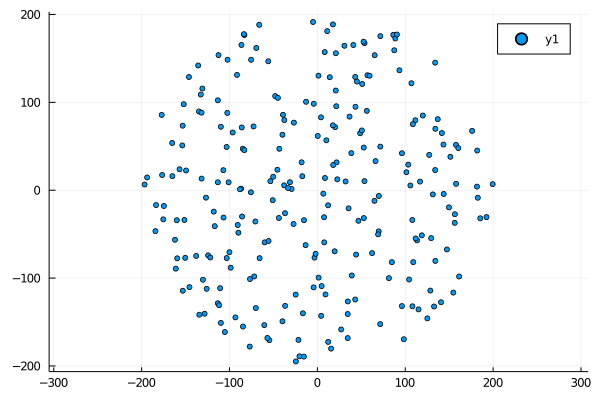

In [255]:
Xmat = vcat(X...)
scatter(Xmat[:, 1], Xmat[:, 2], aspect_ratio=:equal, markersize=3)

In [261]:
b = [1, 2]
a = [-1, 5]
(b - a)/norm(b-a)

2-element Array{Float64,1}:
  0.5547001962252291
 -0.8320502943378437

In [256]:
@time begin
    # Run simulation
    tf = 350
    Xs = [X]
    t = 1
    save_ts = [50, 350]
    while t < (tf + 1)
        # Select new X and θ
        new_v, new_θ = localInteractionsUpdate(dists, θ, v, X, p)
        # Update X
        old_X = X
        X += new_v .* new_θ
        
        # Enforce boundary conditions
        outside = norm.(X) .> R
        X[outside] = old_X[outside]
        
        # Save X at times of interes
        if t in save_ts
            push!(Xs, X)
        end
        if t == tf
            break
        end
        
        # Recompute pairwise distances
        dists = pairwiseDistance(X, euclidDist)
        t += 1
    end
end

  2.142905 seconds (12.64 M allocations: 1.266 GiB, 9.91% gc time)


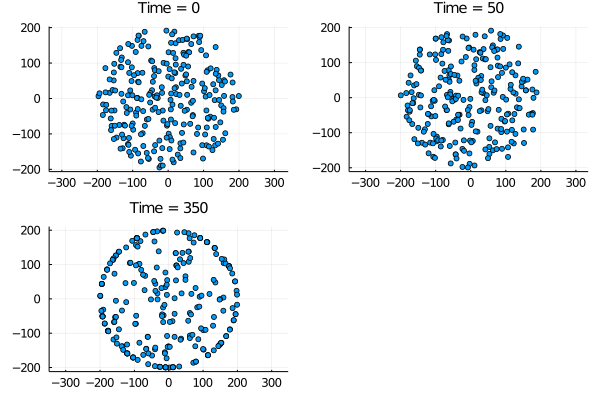

In [257]:
# Visualize
plts = []
for (x, t) in zip(Xs, [0, 50, 350])
    Xmat = vcat(x...)
    plt = scatter(Xmat[:, 1], Xmat[:, 2], aspect_ratio=:equal, legend=false, markersize=3)
    title!("Time = $t")
    push!(plts, plt)
end
plot(plts..., titlefontsize=10)